In [1]:
import torch
from torch import nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision import transforms
from pytorch_model_summary import summary

In [2]:
from utils import *

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
from skimage import feature
import colorsys
import os
import random
from tqdm import tqdm
from skimage.feature import hog
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [4]:
data = load_dataset('data', limit_to=200)

Airport


 56%|█████▌    | 200/360 [00:02<00:02, 75.20it/s]


BareLand


 65%|██████▍   | 200/310 [00:02<00:01, 76.27it/s]


BaseballField


 91%|█████████ | 200/220 [00:02<00:00, 78.81it/s]


Beach


 50%|█████     | 200/400 [00:02<00:02, 85.38it/s]


Bridge


 56%|█████▌    | 200/360 [00:02<00:02, 78.41it/s]


Center


 77%|███████▋  | 200/260 [00:02<00:00, 73.66it/s]


Church


 83%|████████▎ | 200/240 [00:02<00:00, 81.12it/s]


Commercial


 57%|█████▋    | 200/350 [00:02<00:01, 75.25it/s]


DenseResidential


 49%|████▉     | 200/410 [00:02<00:02, 77.93it/s]


Desert


 67%|██████▋   | 200/300 [00:02<00:01, 80.36it/s]


Farmland


 54%|█████▍    | 200/370 [00:02<00:01, 86.94it/s]


Forest


 80%|████████  | 200/250 [00:02<00:00, 78.93it/s]


Industrial


 51%|█████▏    | 200/390 [00:02<00:02, 80.40it/s]


Meadow


 71%|███████▏  | 200/280 [00:02<00:00, 81.24it/s]


MediumResidential


 69%|██████▉   | 200/290 [00:02<00:01, 68.34it/s]


Mountain


 59%|█████▉    | 200/340 [00:02<00:01, 85.03it/s]


Park


 57%|█████▋    | 200/350 [00:02<00:01, 77.63it/s]


Parking


 51%|█████▏    | 200/390 [00:02<00:02, 74.23it/s]


Playground


 54%|█████▍    | 200/370 [00:02<00:02, 83.62it/s]


Pond


 48%|████▊     | 200/420 [00:02<00:02, 90.17it/s]


Port


 53%|█████▎    | 200/380 [00:02<00:01, 91.03it/s]


RailwayStation


 77%|███████▋  | 200/260 [00:02<00:00, 77.72it/s]


Resort


 69%|██████▉   | 200/290 [00:02<00:01, 79.37it/s]


River


 49%|████▉     | 200/410 [00:02<00:02, 84.62it/s]


School


 67%|██████▋   | 200/300 [00:02<00:01, 74.94it/s]


SparseResidential


 67%|██████▋   | 200/300 [00:03<00:01, 63.73it/s]


Square


 61%|██████    | 200/330 [00:02<00:01, 71.95it/s]


Stadium


 69%|██████▉   | 200/290 [00:02<00:01, 70.59it/s]


StorageTanks


 56%|█████▌    | 200/360 [00:02<00:02, 68.81it/s]


Viaduct


 48%|████▊     | 200/420 [00:02<00:02, 75.25it/s]


In [5]:
string_to_id_map = {name: i for i, name in enumerate(data.keys())}

In [6]:
def extract_features(data, model, string_to_id_map):
    # extract model features
    features_list = []
    class_name_list = []
    class_id_list = []
    for class_name, im_list in data.items():
        for im in tqdm(im_list):
            class_name_list.append(class_name)
            class_id_list.append(string_to_id_map[class_name])
            features_list.append(model.process_im(im=im))
        
    features = np.array(features_list)
    class_names = np.array(class_name_list)
    class_ids = np.array(class_id_list)
    return features, class_ids, class_names

In [7]:
resnet_features, resnet_class_ids, resnet_class_names = extract_features(data, ResNet(), string_to_id_map)
print(resnet_features.shape, resnet_class_ids.shape, resnet_class_names.shape)

100%|██████████| 200/200 [00:16<00:00, 12.01it/s]

(6000, 2048) (6000,) (6000,)


In [8]:
effnet_features, effnet_class_ids, effnet_class_names = extract_features(data, EffNet(), string_to_id_map)
print(effnet_features.shape, effnet_class_ids.shape, effnet_class_names.shape)

100%|██████████| 200/200 [01:12<00:00,  2.74it/s]

(6000, 1280) (6000,) (6000,)


In [16]:
import os
os.getcwd()

'c:\\Users\\grays\\Repositories\\281 Computer Vision\\w281-final'

In [20]:
np.save(r"c:\Users\grays\Repositories\281 Computer Vision\w281-final\features\features_class_names.npy", effnet_class_names)

In [9]:
# vgg_features, vgg_class_ids, vgg_class_names = extract_features(data, VGG(), string_to_id_map)
# print(vgg_features.shape, vgg_class_ids.shape, vgg_class_names.shape)

In [22]:
def get_PCA(X_list, n_components=2):
    pca_list = []
    xpca_list = []
    for X in X_list:
        pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
        X_pca = pca.transform(X)
        pca_list.append(pca)
        xpca_list.append(X_pca)
    return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
    pca_list, xpca_list = get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'm-', 'k-']
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
    plt.yticks(np.linspace(0, 1, 8))
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    #plt.savefig(r"c:\Users\grays\Repositories\281 Computer Vision\w281-final\plots\ResNet_EffNet_PCA_explained_200.png")
    plt.show()

def get_tsne(X_list, n_components=2):
    xtsne_list = []
    for X in X_list:
        tsne = TSNE(n_components=n_components, random_state=0)
        X_tsne = tsne.fit_transform(X)
        xtsne_list.append(X_tsne)
    return xtsne_list

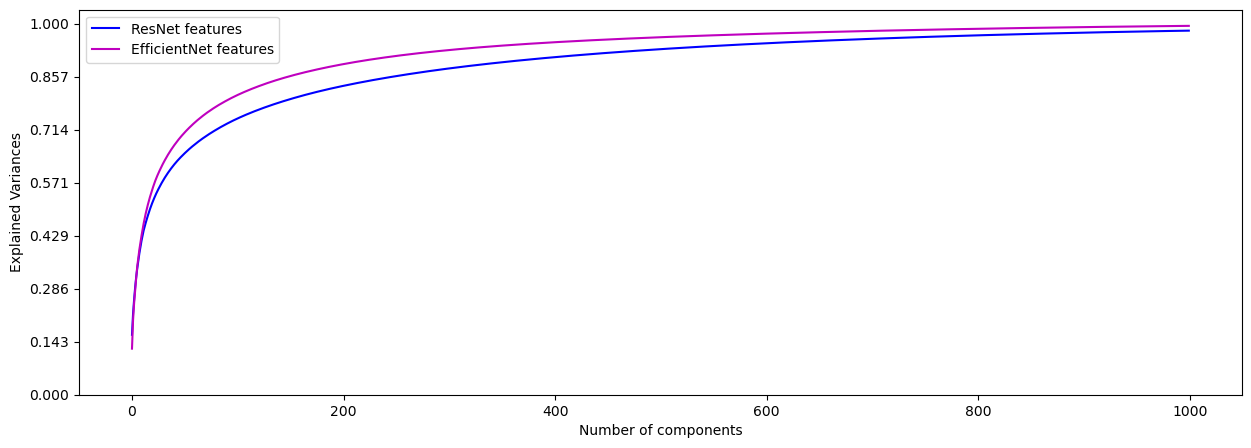

In [23]:
# plot explained variance vs the number of components for PCA
# x = plot_PCA([resnet_features, effnet_features, vgg_features], n_components=500)
x = plot_PCA([resnet_features, effnet_features], labels=["ResNet features", "EfficientNet features"], n_components=1000)

In [12]:
# dimensionality reduction
resnet_pca = get_PCA([resnet_features], n_components=2)[-1]
resnet_tsne = get_tsne([resnet_features], n_components=2)

effnet_pca = get_PCA([effnet_features], n_components=2)[-1]
effnet_tsne = get_tsne([effnet_features], n_components=2)

# vgg_pca = get_PCA([vgg_features], n_components=2)[-1]
# vgg_tsne = get_tsne([vgg_features], n_components=2)

c:\Users\grays\anaconda3\envs\py1torch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\grays\anaconda3\envs\py1torch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\grays\anaconda3\envs\py1torch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\grays\anaconda3\envs\py1torch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]

  # project the features into 2 dimensions
  for k in range(len(np.unique(y))):
    ax.scatter(X[y==k, 0], X[y==k, 1], alpha=0.5, facecolors=colorst[k])

  ax.set_title(title)

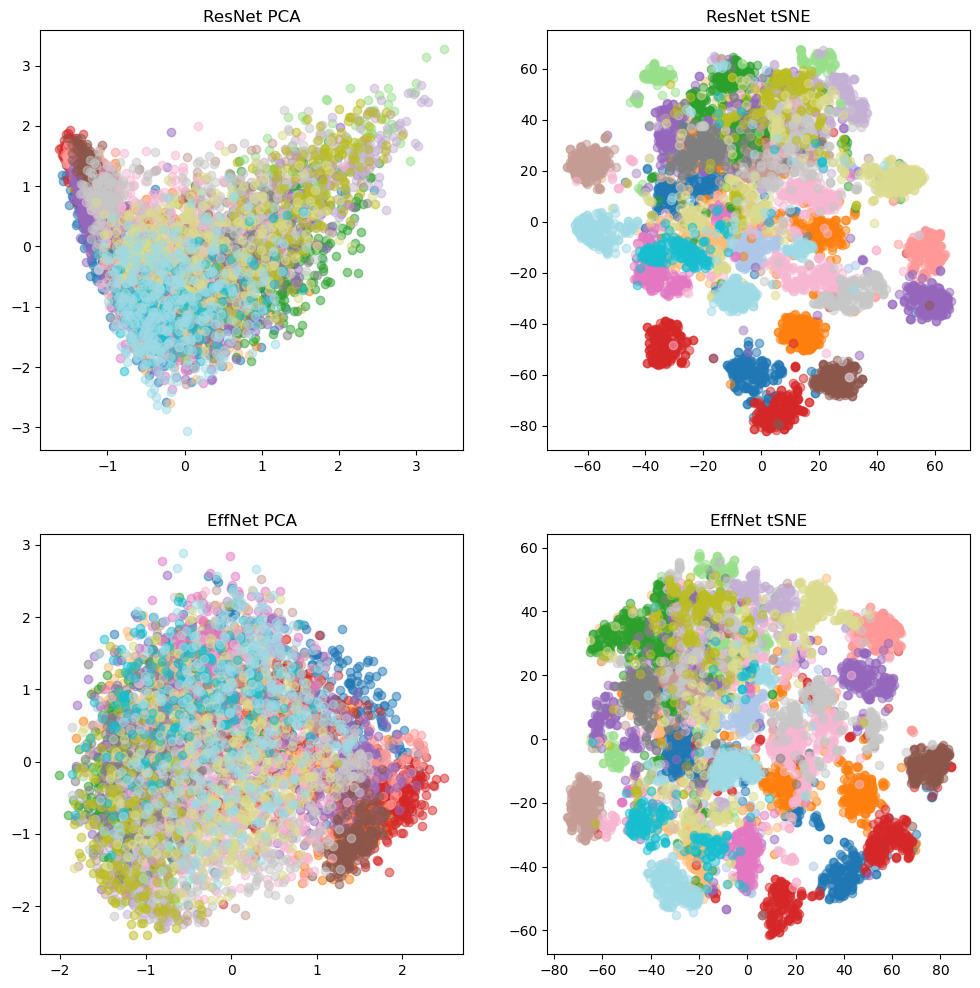

In [21]:
# plot results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

# y is the class labels (person ID)
plot_classes(resnet_pca[0], resnet_class_ids, ax[0,0], title='ResNet PCA')
plot_classes(resnet_tsne[0], resnet_class_ids, ax[0,1], title='ResNet tSNE')

plot_classes(effnet_pca[0], effnet_class_ids, ax[1,0], title='EffNet PCA')
plot_classes(effnet_tsne[0], effnet_class_ids, ax[1,1], title='EffNet tSNE')

# plot_classes(vgg_pca[0], vgg_class_ids, ax[2,0], title='VGG16 PCA')
# plot_classes(vgg_tsne[0], vgg_class_ids, ax[2,1], title='VGG16 tSNE')
plt.savefig(r"c:\Users\grays\Repositories\281 Computer Vision\w281-final\plots\ResNet_EffNet_PCA_tSNE_200.png")
plt.show()